# 身長と体重の関係のモデリング例を通して、ドメイン知識の入れ方を学ぶ
参考: [ビジネス課題を解決する技術](https://gihyo.jp/book/2025/978-4-297-14992-5)

In [36]:
# モジュールインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## データ取得

In [19]:
# 以下のサイトから身長と体重のデータを取得する
# https://www.e-stat.go.jp/dbview?sid=0003224177

cols = ["年齢階級","男性身長","男性体重","女性身長","女性体重"]
data = [
    ["1歳",79.6,10.3,76.6,9.7],
    ["2歳",89.0,12.2,88.2,12.3],
    ["3歳",95.6,13.8,95.7,13.9],
    ["4歳",103.7,16.4,102.9,16.5],
    ["5歳",110.5,18.2,107.5,17.7],
    ["6歳",114.9,20.6,114.7,20.4],
    ["7歳",122.7,24.7,121.1,21.8],
    ["8歳",126.3,25.8,125.5,25.9],
    ["9歳",132.5,30.1,133.1,30.4],
    ["10歳",138.1,33.9,138.7,32.2],
    ["11歳",147.2,41.3,144.0,36.5],
    ["12歳",148.0,41.3,150.9,41.9],
    ["13歳",156.5,44.7,154.8,48.8],
    ["14歳",166.8,56.1,155.5,48.4],
    ["15歳",169.3,59.2,159.2,51.2],
    ["16歳",168.9,60.8,158.0,48.9],
    ["17歳",171.5,64.0,158.4,52.6],
    ["18歳",171.1,61.2,156.0,49.6],
    ["19歳",170.4,60.6,156.7,48.7],
    ["20歳",170.2,57.0,158.6,49.0],
    ["21歳",168.7,64.8,158.7,54.6],
    ["22歳",172.3,65.3,159.0,52.3],
    ["23歳",171.6,72.7,155.9,51.3],
    ["24歳",172.7,68.6,155.9,49.2],
    ["25歳",171.3,63.6,156.9,52.4],
    ["26歳-29歳",171.8,70.4,157.9,53.4],
    ["30歳-39歳",171.5,70.0,158.2,54.3],
    ["40歳-49歳",171.5,72.8,158.1,55.6],
    ["50歳-59歳",169.9,71.0,156.9,55.2],
    ["60歳-69歳",167.4,67.3,154.0,54.7],
    ["70歳以上",163.1,62.4,149.4,51.1],
]
df_wide = pd.DataFrame(data, columns=cols)
men = (df_wide
       .rename(columns={"男性身長":"height", "男性体重":"weight"})
       [["年齢階級","height","weight"]]
       .assign(gender="men",
               age_band=lambda d: "mens_" + d["年齢階級"]))
women = (df_wide
         .rename(columns={"女性身長":"height", "女性体重":"weight"})
         [["年齢階級","height","weight"]]
         .assign(gender="women",
                 age_band=lambda d: "womens_" + d["年齢階級"]))

df = pd.concat([men, women], ignore_index=True)[["age_band","gender","height","weight"]]
df

,age_band,gender,height,weight
0,mens_1歳,men,79.6,10.3
1,mens_2歳,men,89.0,12.2
2,mens_3歳,men,95.6,13.8
3,mens_4歳,men,103.7,16.4
4,mens_5歳,men,110.5,18.2
...,...,...,...,...
57,womens_30歳-39歳,women,158.2,54.3
58,womens_40歳-49歳,women,158.1,55.6
59,womens_50歳-59歳,women,156.9,55.2
60,womens_60歳-69歳,women,154.0,54.7


## 設定
- 身長100〜140の体重は既知で、それ以外の人を予測したい状況とする

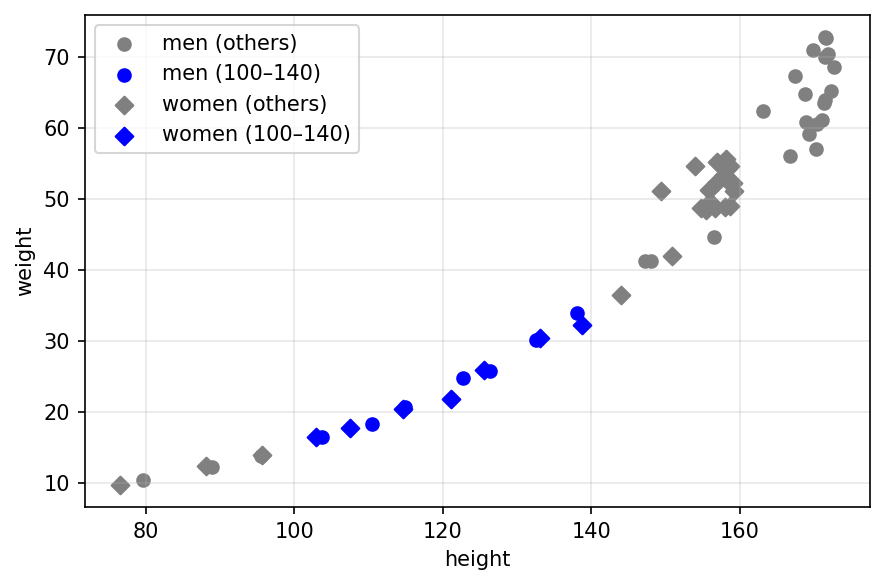

In [38]:
# 散布図を描画する
mask_women = df["gender"].eq("women")
mask_blue = df["height"].between(100, 140, inclusive="both")

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# 男性（グレー→青の順で重ねる）
ax.scatter(df.loc[~mask_women & ~mask_blue, "height"],
           df.loc[~mask_women & ~mask_blue, "weight"],
           color="gray", label="men (others)")
ax.scatter(df.loc[~mask_women & mask_blue, "height"],
           df.loc[~mask_women & mask_blue, "weight"],
           color="blue", label="men (100–140)", zorder=3)

# 女性（ダイヤ型、グレー→青の順で重ねる）
ax.scatter(df.loc[mask_women & ~mask_blue, "height"],
           df.loc[mask_women & ~mask_blue, "weight"],
           color="gray", marker="D", label="women (others)")
ax.scatter(df.loc[mask_women & mask_blue, "height"],
           df.loc[mask_women & mask_blue, "weight"],
           color="blue", marker="D", label="women (100–140)", zorder=4)

ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### アプローチ1
$
\mathbb{E}[Y\mid x] = \alpha + \beta x
$

alpha=-34.763, beta=0.485
E[Y|x] = -34.763 + 0.485 x
R^2_blue=0.974, R^2_all=0.632


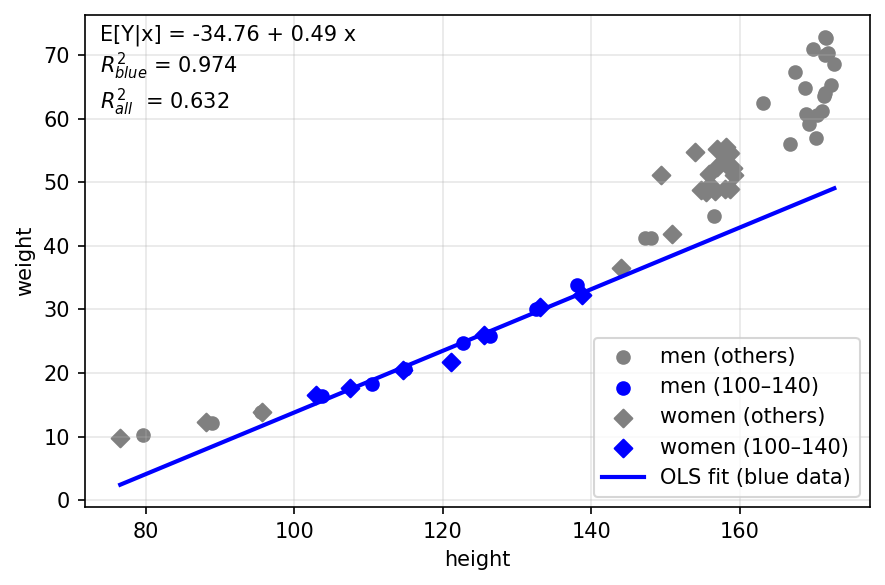

In [32]:
# 色分けマスク
mask_women = df["gender"].eq("women")
mask_blue  = df["height"].between(100, 140, inclusive="both")

# --- 青データで OLS: E[Y|x] = α + βx ---
x_b = df.loc[mask_blue, "height"].to_numpy()
y_b = df.loc[mask_blue, "weight"].to_numpy()
beta, alpha = np.polyfit(x_b, y_b, 1)  # slope, intercept

def r2_score(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

r2_blue = r2_score(y_b, alpha + beta * x_b)

# 全データに対する R^2
x_all = df["height"].to_numpy()
y_all = df["weight"].to_numpy()
r2_all = r2_score(y_all, alpha + beta * x_all)

print(f"alpha={alpha:.3f}, beta={beta:.3f}")
print(f"E[Y|x] = {alpha:.3f} + {beta:.3f} x")
print(f"R^2_blue={r2_blue:.3f}, R^2_all={r2_all:.3f}")

# --- プロット（女性=ダイヤ / 100–140=青, それ以外=グレー） ---
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# men
ax.scatter(df.loc[~mask_women & ~mask_blue, "height"],
           df.loc[~mask_women & ~mask_blue, "weight"],
           color="gray", label="men (others)")
ax.scatter(df.loc[~mask_women & mask_blue, "height"],
           df.loc[~mask_women & mask_blue, "weight"],
           color="blue", label="men (100–140)", zorder=3)

# women (diamond)
ax.scatter(df.loc[mask_women & ~mask_blue, "height"],
           df.loc[mask_women & ~mask_blue, "weight"],
           color="gray", marker="D", label="women (others)")
ax.scatter(df.loc[mask_women & mask_blue, "height"],
           df.loc[mask_women & mask_blue, "weight"],
           color="blue", marker="D", label="women (100–140)", zorder=4)

# 回帰直線を min〜max に延長
xs = np.linspace(df["height"].min(), df["height"].max(), 200)
ax.plot(xs, alpha + beta * xs, color="blue", linewidth=2, label="OLS fit (blue data)")

# 式と R^2（blue/all）を表示
ax.text(0.02, 0.98,
        f"E[Y|x] = {alpha:.2f} + {beta:.2f} x\n"
        f"$R^2_{{blue}}$ = {r2_blue:.3f}\n"
        f"$R^2_{{all}}$  = {r2_all:.3f}",
        transform=ax.transAxes, ha="left", va="top")

ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### アプローチ2
$
\mathbb{E}[Y\mid x] = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3
$

E[Y|x] = 420.839 + -10.272 x + 0.084 x^2 + -0.000 x^3
R^2_blue=0.989, R^2_all=0.185


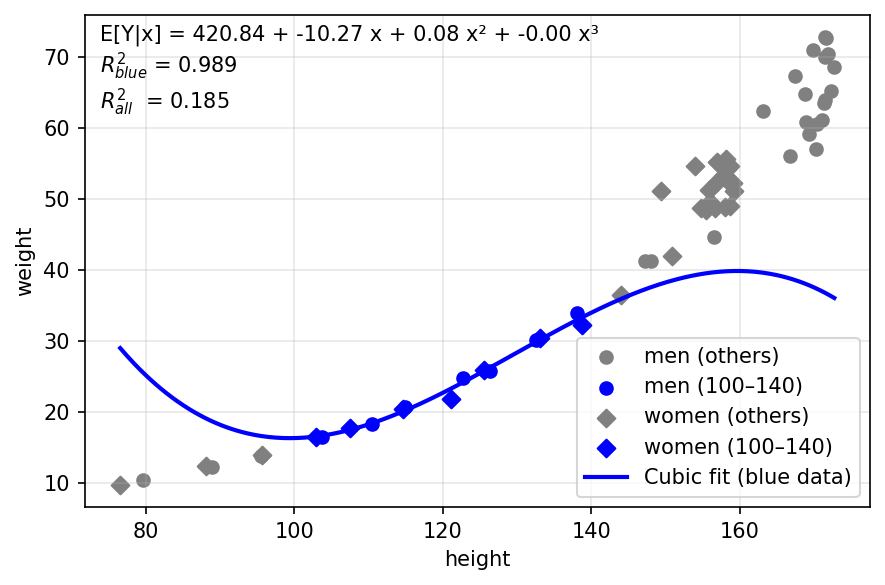

In [34]:
# --- マスク作成 ---
mask_women = df["gender"].eq("women")
mask_blue  = df["height"].between(100, 140, inclusive="both")

# --- 青データで三次多項式回帰: E[Y|x] = β0 + β1 x + β2 x^2 + β3 x^3 ---
x_b = df.loc[mask_blue, "height"].to_numpy()
y_b = df.loc[mask_blue, "weight"].to_numpy()

coefs = np.polyfit(x_b, y_b, 3)  # returns [c3, c2, c1, c0]
beta_3, beta_2, beta_1, beta_0 = coefs[0], coefs[1], coefs[2], coefs[3]

# R^2 関数
def r2_score(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# R^2（青／全体）
r2_blue = r2_score(y_b, np.polyval(coefs, x_b))
x_all = df["height"].to_numpy()
y_all = df["weight"].to_numpy()
r2_all  = r2_score(y_all, np.polyval(coefs, x_all))

print(f"E[Y|x] = {beta_0:.3f} + {beta_1:.3f} x + {beta_2:.3f} x^2 + {beta_3:.3f} x^3")
print(f"R^2_blue={r2_blue:.3f}, R^2_all={r2_all:.3f}")

# --- プロット（女性はダイヤ / 100–140=青, それ以外=グレー） ---
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# men
ax.scatter(df.loc[~mask_women & ~mask_blue, "height"],
           df.loc[~mask_women & ~mask_blue, "weight"],
           color="gray", label="men (others)")
ax.scatter(df.loc[~mask_women & mask_blue, "height"],
           df.loc[~mask_women & mask_blue, "weight"],
           color="blue", label="men (100–140)", zorder=3)

# women (diamond)
ax.scatter(df.loc[mask_women & ~mask_blue, "height"],
           df.loc[mask_women & ~mask_blue, "weight"],
           color="gray", marker="D", label="women (others)")
ax.scatter(df.loc[mask_women & mask_blue, "height"],
           df.loc[mask_women & mask_blue, "weight"],
           color="blue", marker="D", label="women (100–140)", zorder=4)

# 予測曲線（全範囲）
xs = np.linspace(df["height"].min(), df["height"].max(), 400)
ax.plot(xs, np.polyval(coefs, xs), color="blue", linewidth=2,
        label="Cubic fit (blue data)")

# 式と R^2 を図中に表示
ax.text(0.02, 0.98,
        (f"E[Y|x] = {beta_0:.2f} + {beta_1:.2f} x + {beta_2:.2f} x² + {beta_3:.2f} x³\n"
         f"$R^2_{{blue}}$ = {r2_blue:.3f}\n"
         f"$R^2_{{all}}$  = {r2_all:.3f}"),
        transform=ax.transAxes, ha="left", va="top")

ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### アプローチ3
$
\mathbb{E}[Y\mid x] = \theta x^3
$

theta = 0.000013
E[Y|x] = 0.000013 x^3
R^2_blue=0.953, R^2_all=0.967


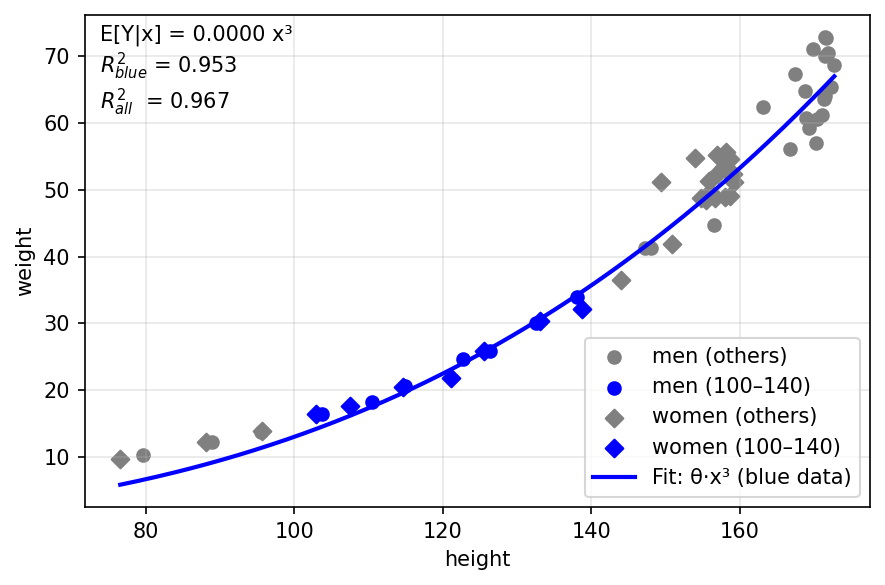

In [35]:
# マスク
mask_women = df["gender"].eq("women")
mask_blue  = df["height"].between(100, 140, inclusive="both")

# --- 青データで θ を推定（最小二乗・切片なし） ---
x_b = df.loc[mask_blue, "height"].to_numpy()
y_b = df.loc[mask_blue, "weight"].to_numpy()

z_b = x_b ** 3
theta = (z_b @ y_b) / (z_b @ z_b)  # θ = (∑x^3 y)/(∑x^6)

# R^2（平均まわりの定義で計算）
def r2(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

r2_blue = r2(y_b, theta * z_b)

x_all = df["height"].to_numpy()
y_all = df["weight"].to_numpy()
r2_all = r2(y_all, theta * (x_all ** 3))

print(f"theta = {theta:.6f}")
print(f"E[Y|x] = {theta:.6f} x^3")
print(f"R^2_blue={r2_blue:.3f}, R^2_all={r2_all:.3f}")

# --- プロット（女性=ダイヤ / 100–140=青, その他=グレー） ---
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# men
ax.scatter(df.loc[~mask_women & ~mask_blue, "height"],
           df.loc[~mask_women & ~mask_blue, "weight"],
           color="gray", label="men (others)")
ax.scatter(df.loc[~mask_women & mask_blue, "height"],
           df.loc[~mask_women & mask_blue, "weight"],
           color="blue", label="men (100–140)", zorder=3)

# women (diamond)
ax.scatter(df.loc[mask_women & ~mask_blue, "height"],
           df.loc[mask_women & ~mask_blue, "weight"],
           color="gray", marker="D", label="women (others)")
ax.scatter(df.loc[mask_women & mask_blue, "height"],
           df.loc[mask_women & mask_blue, "weight"],
           color="blue", marker="D", label="women (100–140)", zorder=4)

# 予測曲線（全範囲）
xs = np.linspace(df["height"].min(), df["height"].max(), 400)
ax.plot(xs, theta * (xs ** 3), color="blue", linewidth=2,
        label="Fit: θ·x³ (blue data)")

# 式と R^2 を図中に表示
ax.text(0.02, 0.98,
        f"E[Y|x] = {theta:.4f} x³\n"
        f"$R^2_{{blue}}$ = {r2_blue:.3f}\n"
        f"$R^2_{{all}}$  = {r2_all:.3f}",
        transform=ax.transAxes, ha="left", va="top")

ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()